### First lab figures - 18 Oct 2017
+ All data vs normal range
+ Statistical Test

#### Notes - 25 Oct 2017

+ Change to non-parametric test to avoid assumption on the normal distribution, from two sample t-test to Mann-Whitney U test
+ Overlapping coefficient: $$OVL = \int_{-\infty}^\infty min [f_1(x), f_2(x)] \, dx $$
+ Notes when using Python implementation of integral: <br><br>
    - scipy.integrate.quat use heuristic algorithms, using adaptative step of integration to reduce time computing. Where the function is flat, it goes faster. so on big global interval, **it can miss the peak**. Reference: https://stackoverflow.com/questions/34877147/limits-of-quad-integration-in-scipy-with-np-inf <br><br>
    - In this script, for most of the lab tests, the peak is not missed. However, for __chloride__ __glucose__ and __sodium__, the integral from neg-infinity to infinity is 0 while integral over peak interval is reasonable -> peak is missed.<br><br>
    - In addition, for other cases instead of -inf to inf, we may use points=[val1, val2] to specify a focus interval, which can prevent the function from missing the peak. However, for -inf to inf, the points argument is not available.In my implementation, I use a relatively large interval to integrate instead of -inf to inf, with/without focus interval.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy import integrate
from sklearn.neighbors import KernelDensity
import scipy.stats
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(20171024)

In [3]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'ALBUMIN':[3.5, 5.5], 
              'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'GLUCOSE':[70.0, 100.0],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145],
              'FREECALCIUM': [1.1, 1.35],
              'WBC': [3.5, 10.5]
             }
labs = dict((i, 0) for i in lab_ranges.keys())

mimic = pd.read_csv("all_data_minmax.csv", index_col=0)
lab_columns = mimic.columns.values[1:]
data = mimic.copy()

In [4]:
#data.sort_values(by=['los'])
data[['subject_id', 'sodium_min', 'sodium_max']].head()

,subject_id,sodium_min,sodium_max
0,3,136.0,153.0
1,4,135.0,141.0
2,6,134.0,138.0
3,9,136.0,140.0
4,11,138.0,142.0


In [5]:
data.columns

Index([u'subject_id', u'hadm_id', u'icustay_id', u'mort_icu', u'mort_hosp',
       u'mechvent', u'vasopressor', u'gender', u'first_careunit',
       u'last_careunit', u'oasis', u'los', u'first_admit_age', u'charttime',
       u'aniongap_max', u'aniongap_min', u'albumin_max', u'albumin_min',
       u'bicarbonate_max', u'bicarbonate_min', u'bilirubin_max',
       u'bilirubin_min', u'creatinine_max', u'creatinine_min', u'chloride_max',
       u'chloride_min', u'glucose_max', u'glucose_min', u'hematocrit_max',
       u'hematocrit_min', u'hemoglobin_max', u'hemoglobin_min', u'lactate_max',
       u'lactate_min', u'magnesium_max', u'magnesium_min', u'phosphate_max',
       u'phosphate_min', u'platelet_max', u'platelet_min', u'potassium_max',
       u'potassium_min', u'ptt_max', u'ptt_min', u'inr_max', u'inr_min',
       u'pt_max', u'pt_min', u'sodium_max', u'sodium_min', u'bun_max',
       u'bun_min', u'wbc_max', u'wbc_min', u'calcium_max', u'calcium_min',
       u'freecalcium_max', u'freeca

## Minimum Value Plots

In [6]:
def ResumeNorm(val1, val2):
    norm_dist = scipy.stats.norm
    norm_val1 = norm_dist.ppf(0.025)
    norm_val2 = norm_dist.ppf(0.975)
    a = (val1 - val2) / (norm_val1 - norm_val2)
    b = val1 - a * norm_val1
    return scipy.stats.norm(b, a)

In [7]:
def OverlapParam(dist1, dist2, lab):
    """
        Overlapping coefficient: integration of min value of two distribution over R. 
        For chloride, glucose, sodium, use large interval with focus point interval instead. 
    """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    if lab in ['CHLORIDE', 'GLUCOSE', 'SODIUM']:
        return integrate.quad(func, 0, 1000)
    else:
        return integrate.quad(func, -np.inf, np.inf)

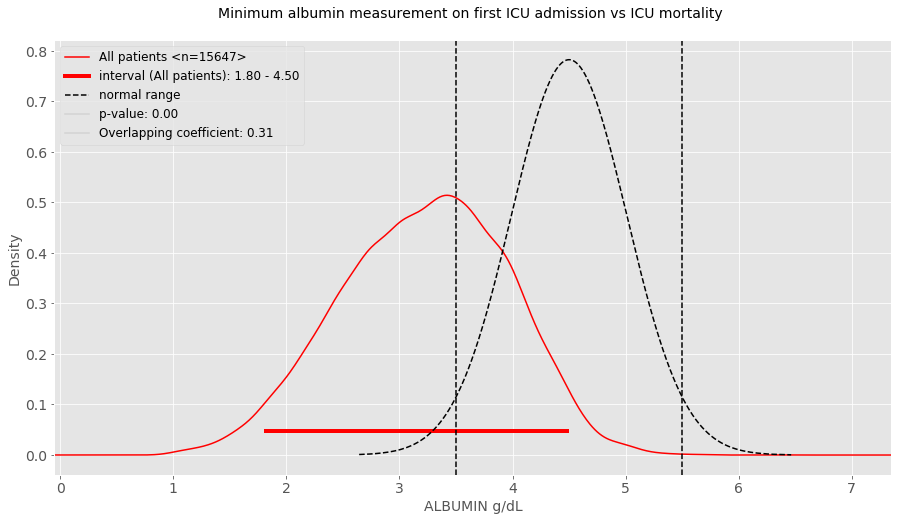

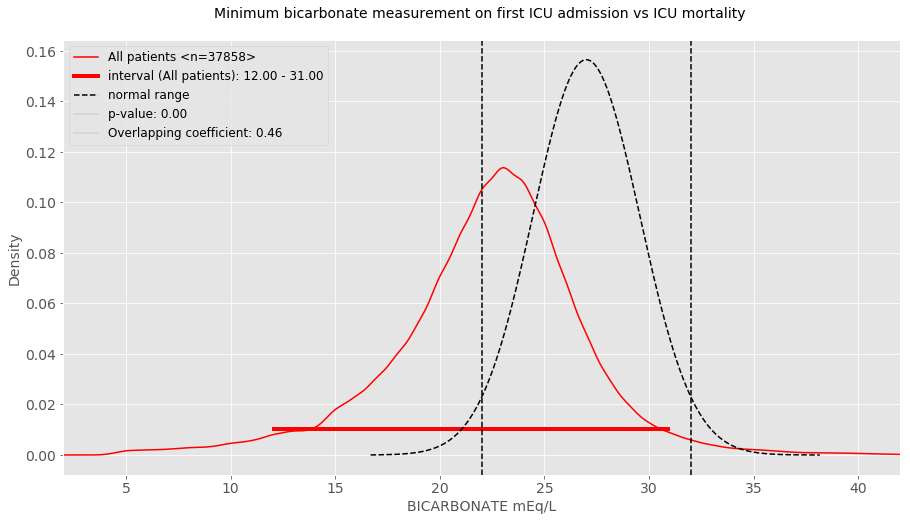

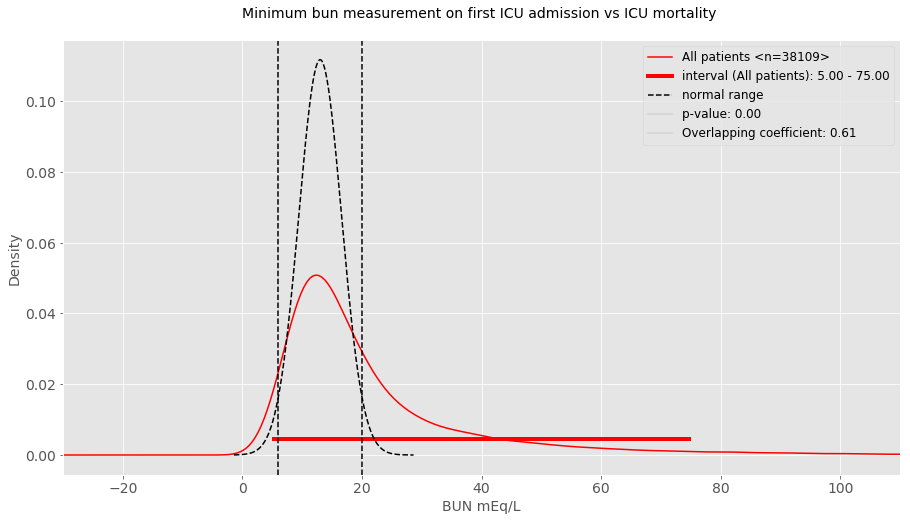

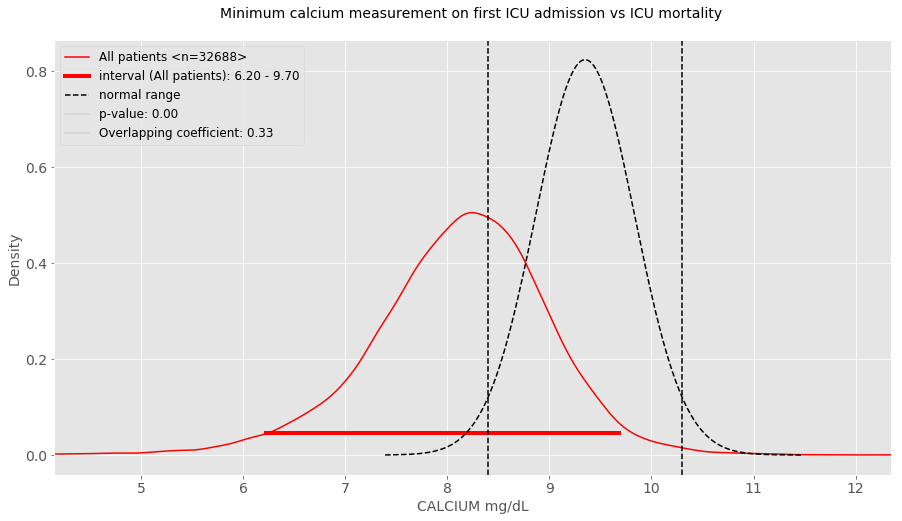

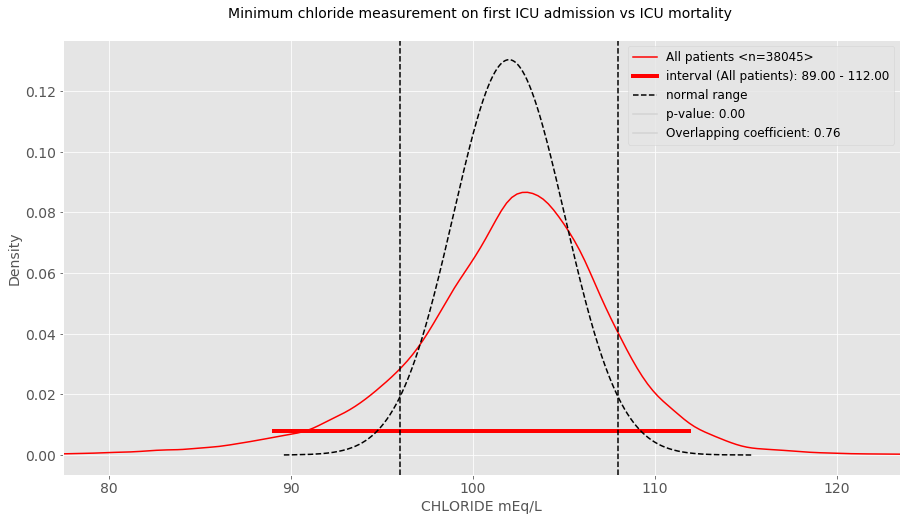

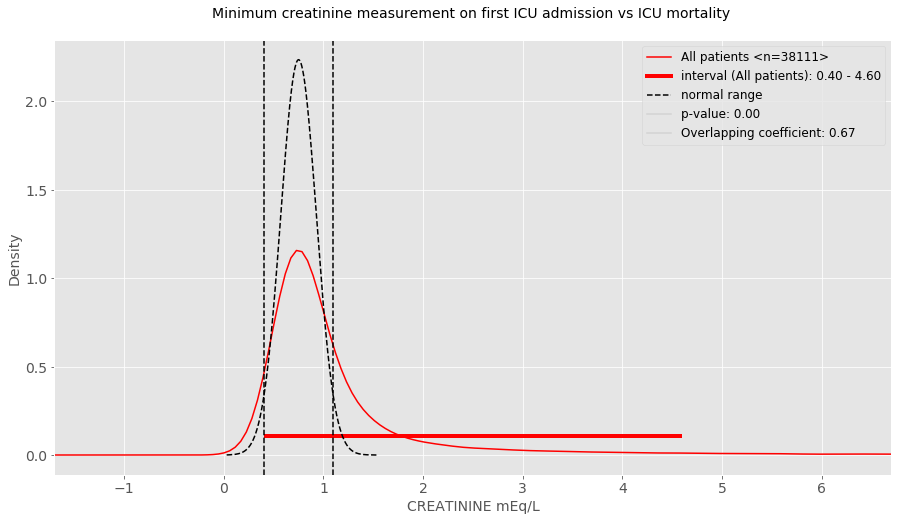

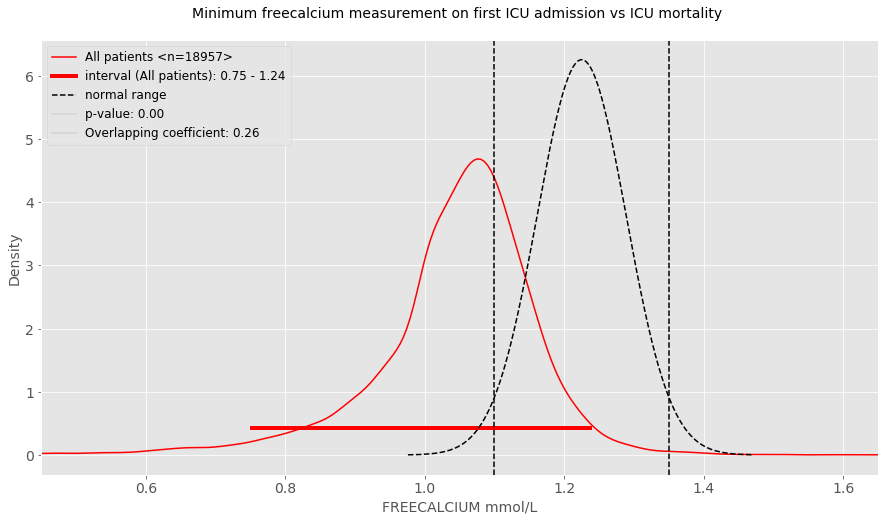

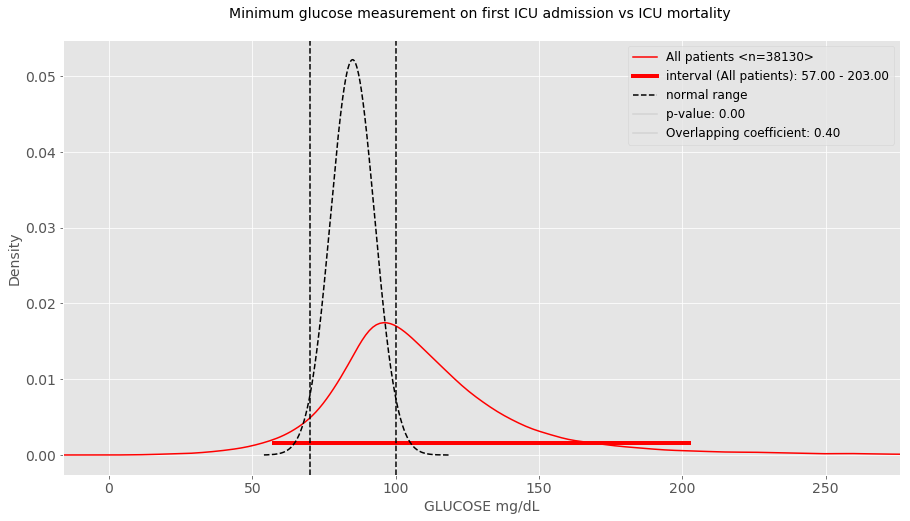

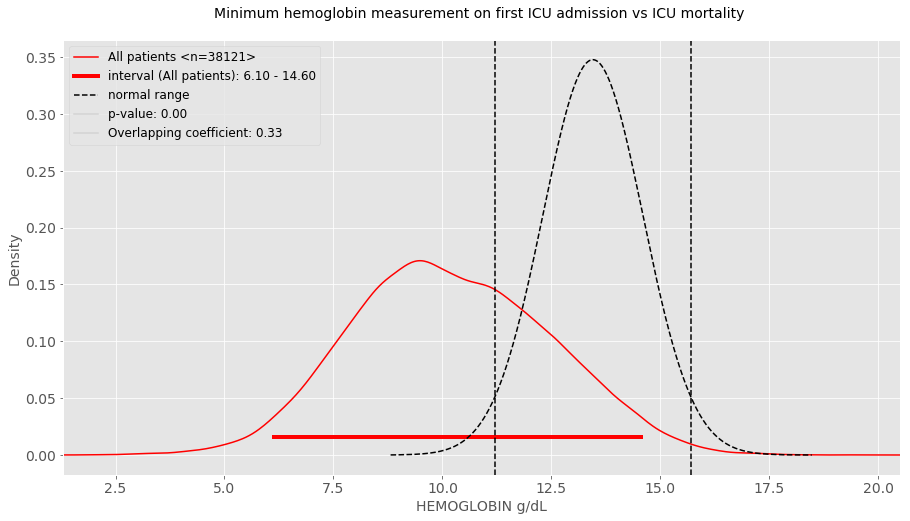

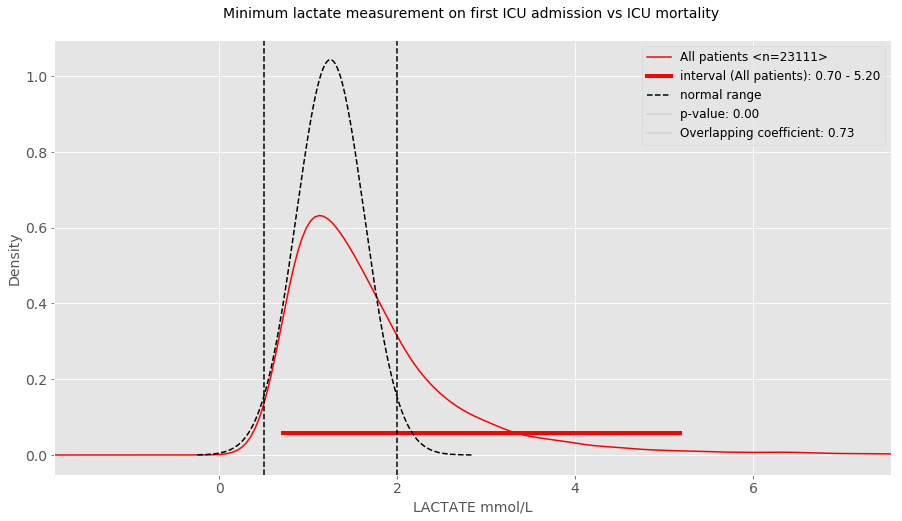

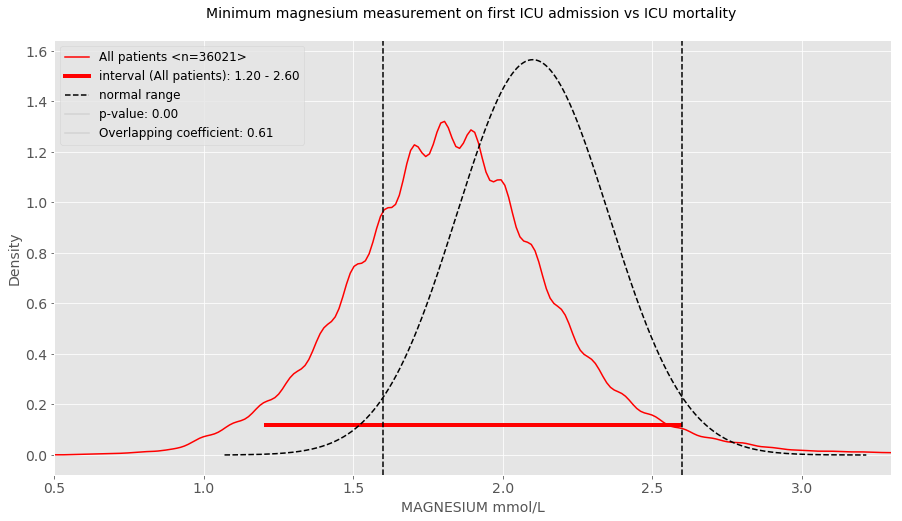

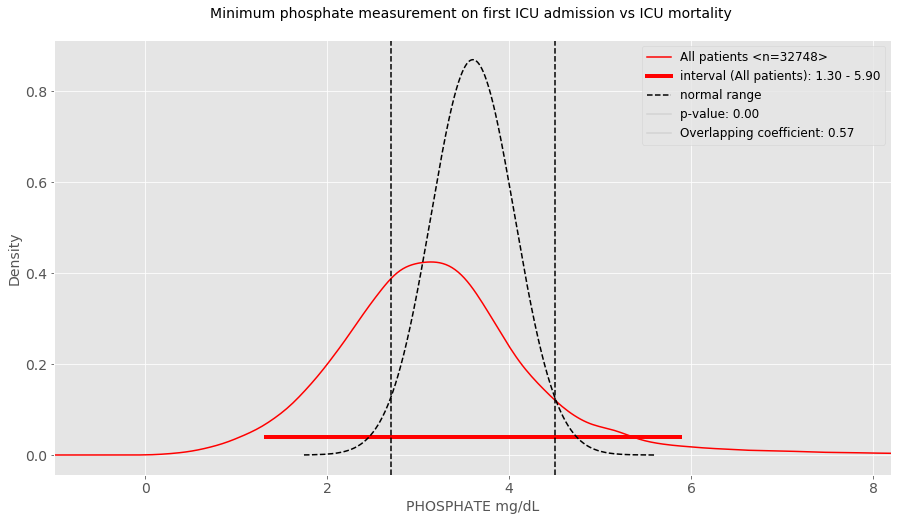

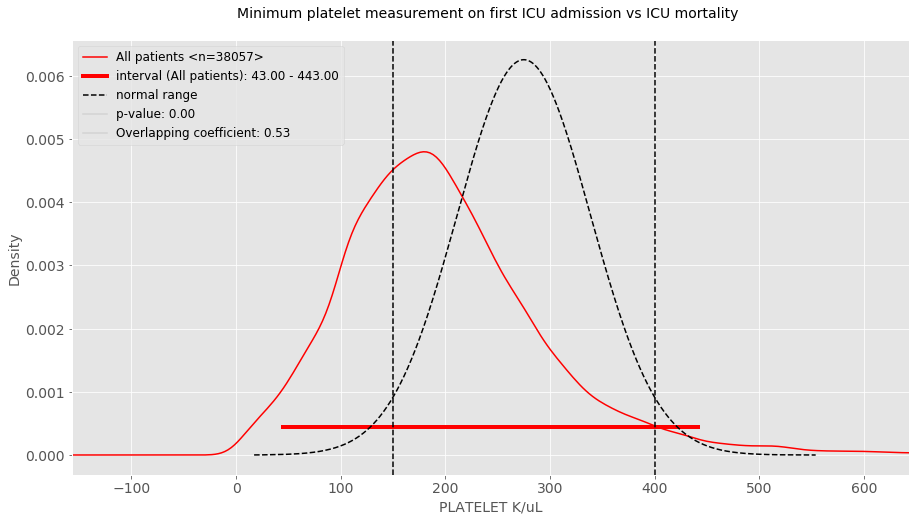

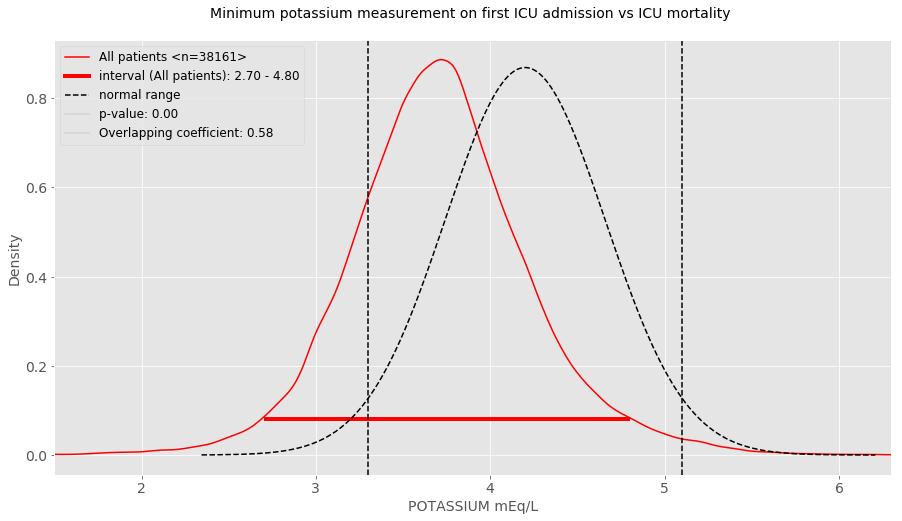

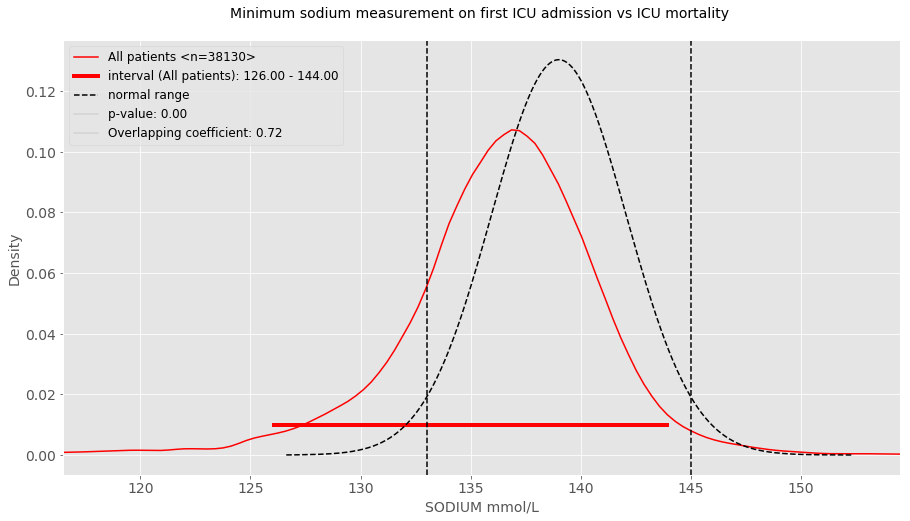

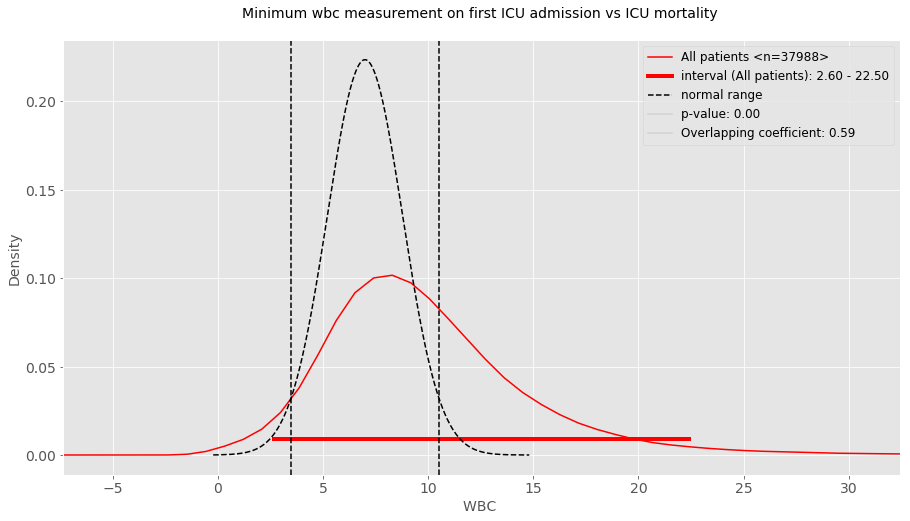

In [8]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
       'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

cond_less = data.mort_icu == 0 

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_all = data[l.lower()+'_min'].dropna().count()

    # get median, variance, mean
    med_all = data[l.lower()+'_min'].dropna().median()
    var_all = data[l.lower()+'_min'].dropna().var()
    mean_all = data[l.lower()+'_min'].dropna().mean()
    
    # Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[l][0], lab_ranges[l][1])
    norm_sample = range_dist.rvs(size=n_all, random_state=20171024)
    
    # Change to non-parametric test to avoid making assumptions
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_min'].dropna())
    t_stat, p_val = mannwhitneyu(norm_sample, data[l.lower()+'_min'].dropna())

    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    data[l.lower()+'_min'].dropna().plot.kde(
        alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data_kde = gaussian_kde(data[l.lower()+'_min'].dropna().as_matrix())
    #plt.plot(data[l.lower()+'_min'].dropna().sort_values(), data_kde.pdf(data[l.lower()+'_min'].dropna().sort_values()))
    
    ovl = OverlapParam(data_kde, range_dist, l)
    # add 95% percentail 
    a1 = data[l.lower()+'_min'].quantile(0.025)
    a2 = data[l.lower()+'_min'].quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    
    # Plot label
    plt.plot([], label='interval (All patients): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='red', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Minimum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)

## Maximum Value Plots

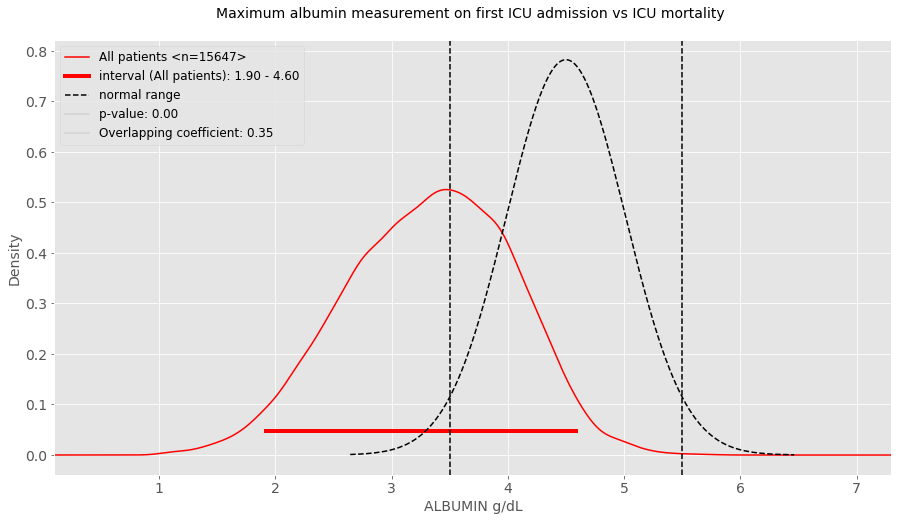

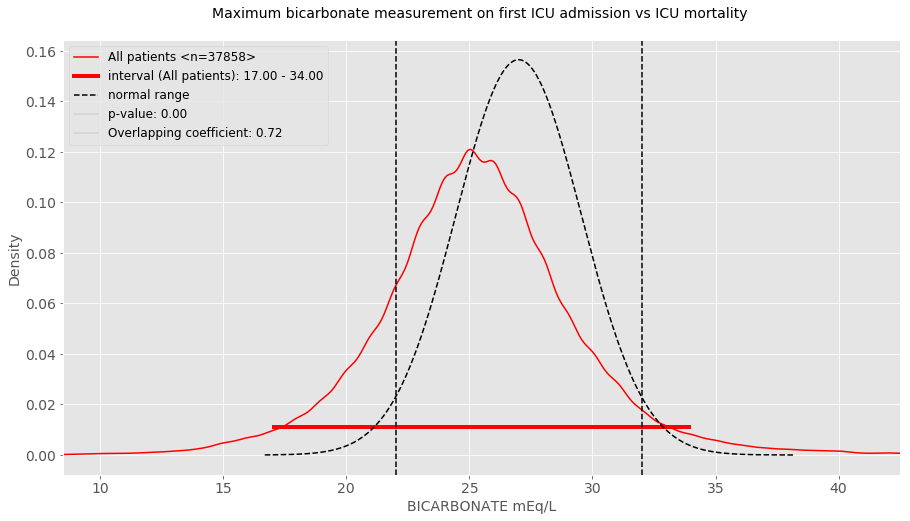

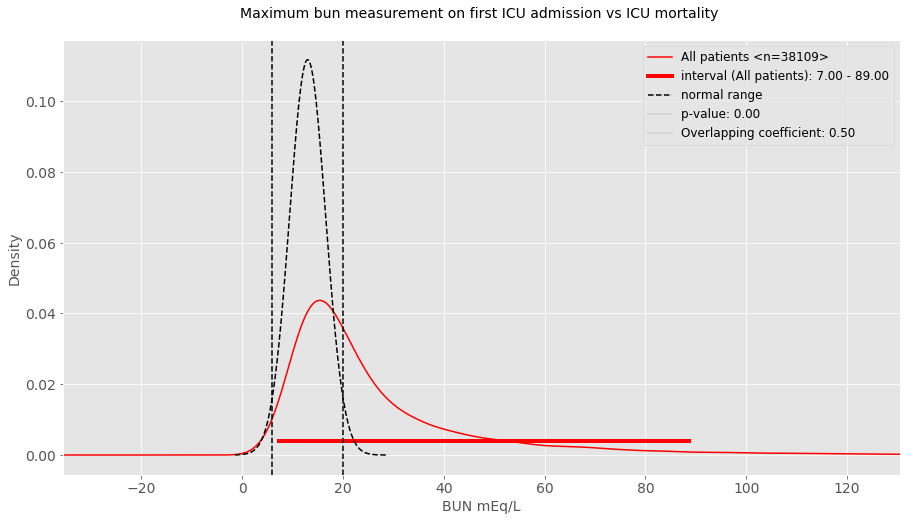

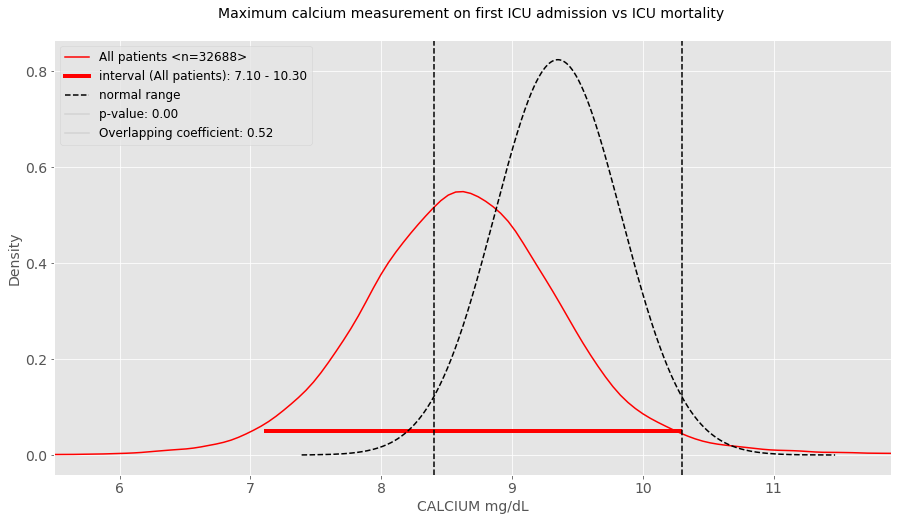

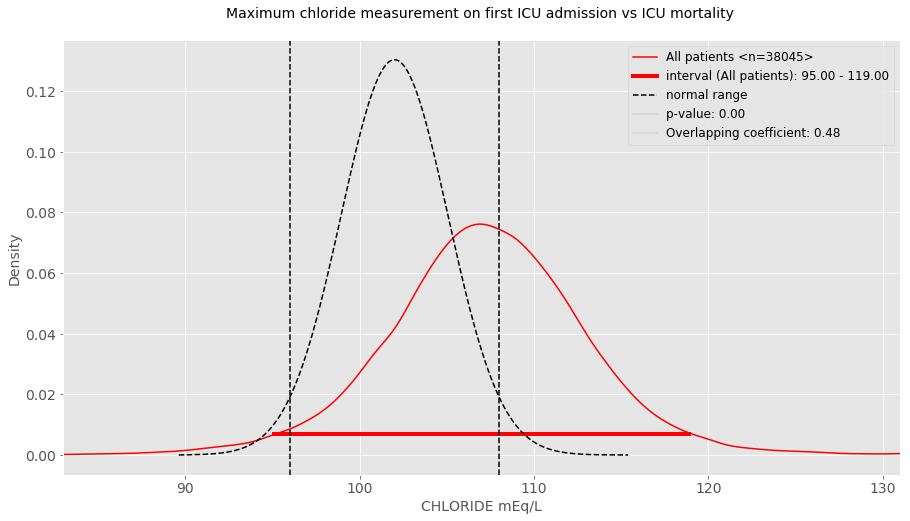

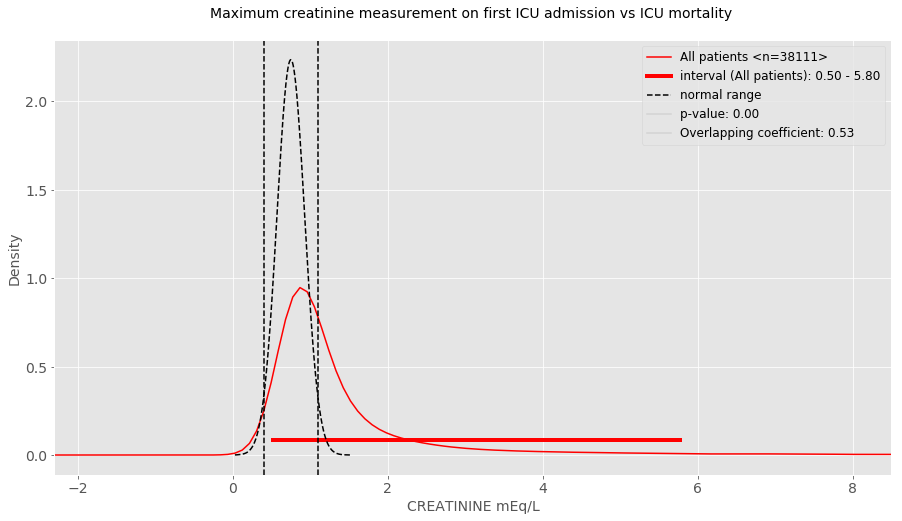

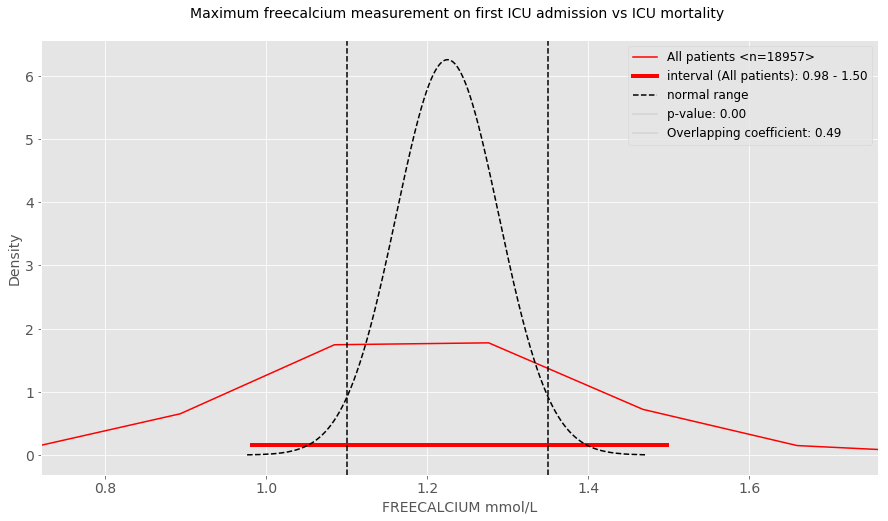

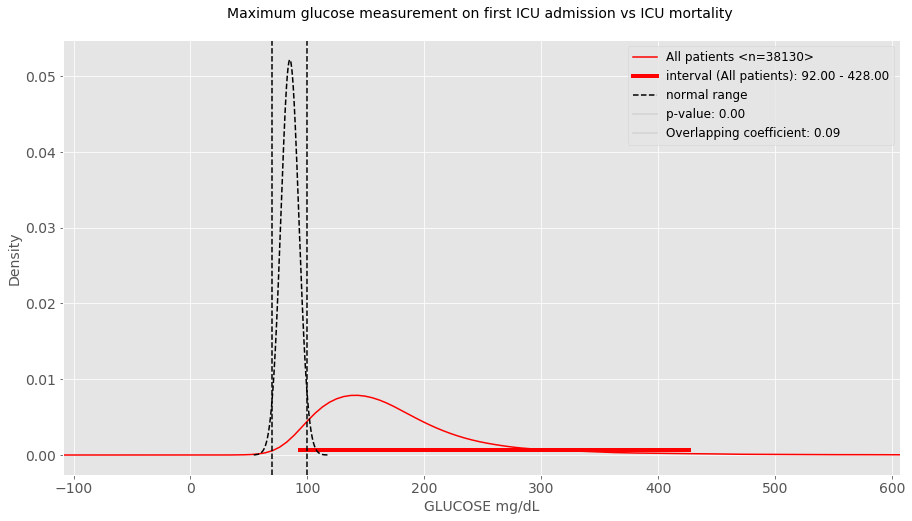

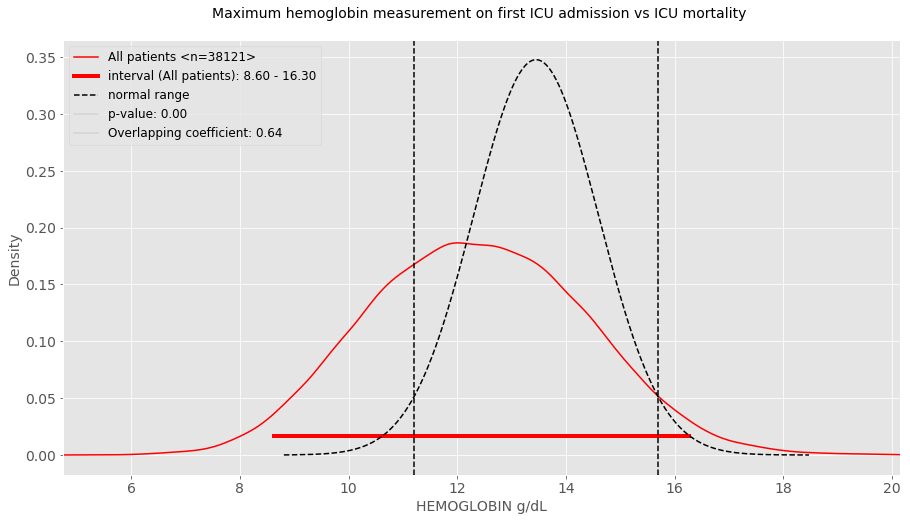

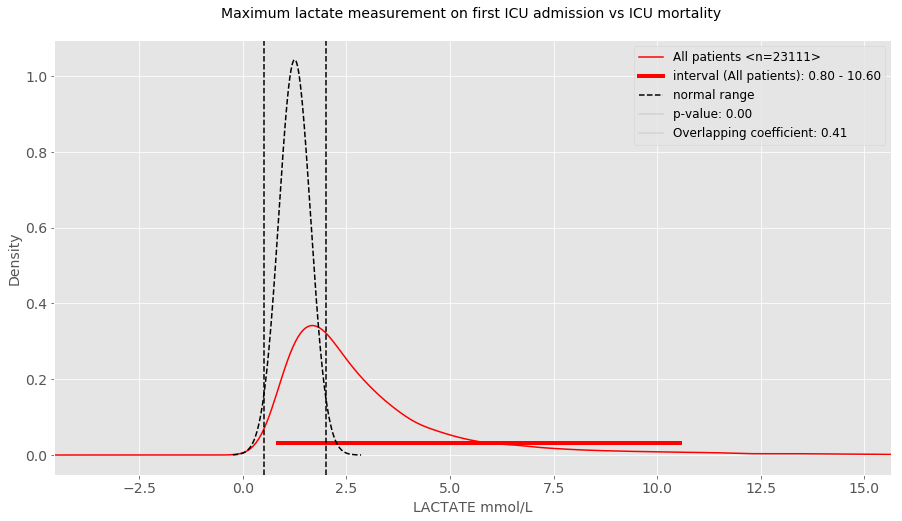

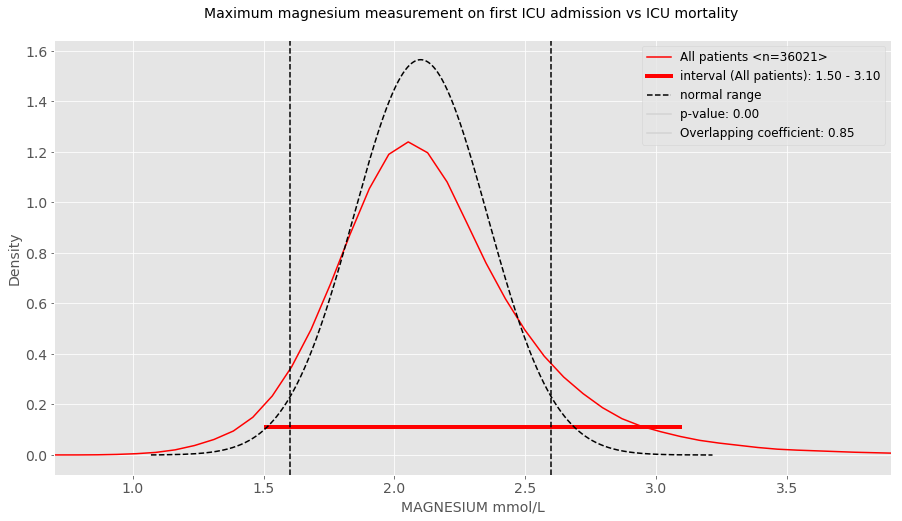

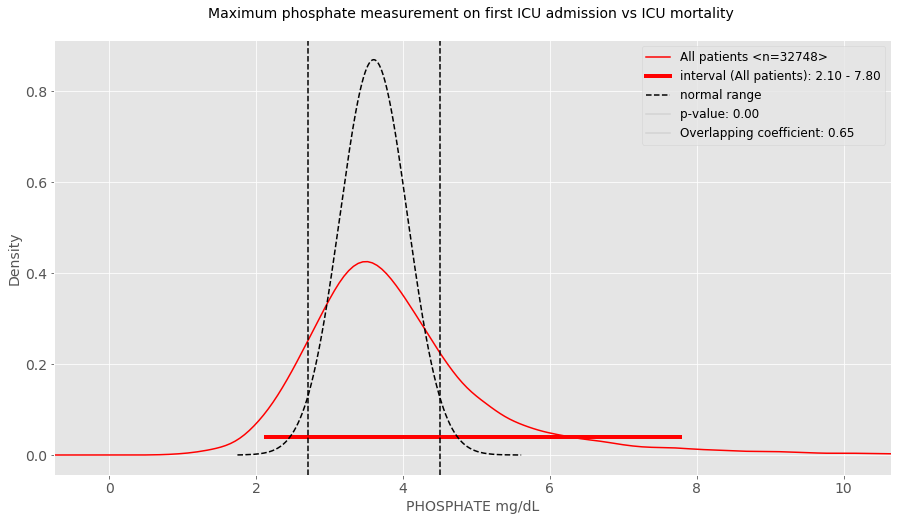

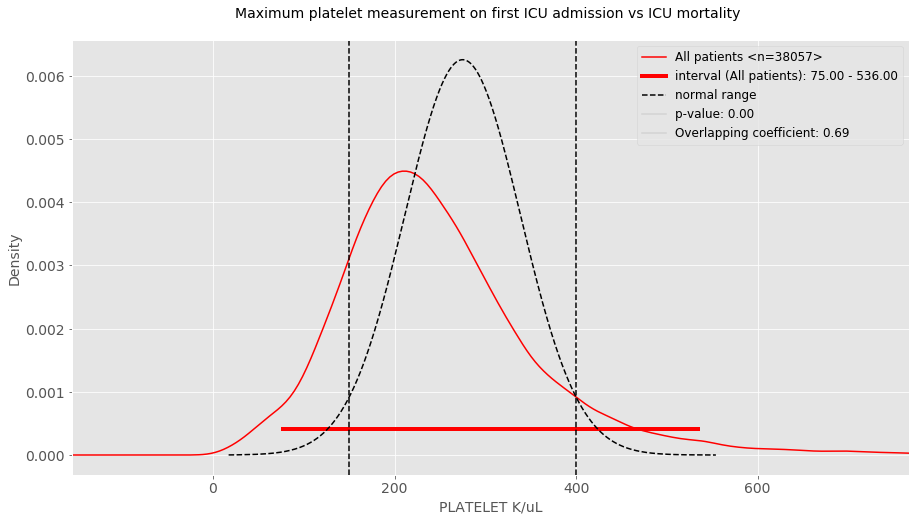

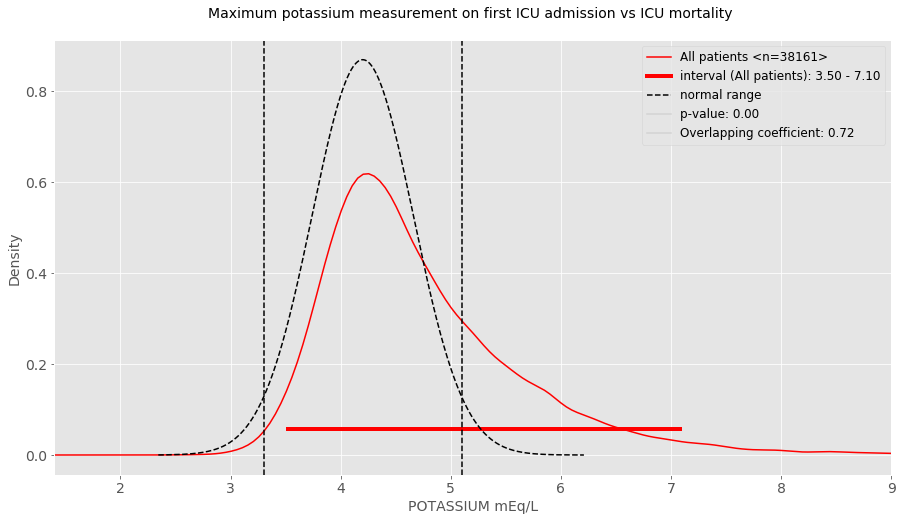

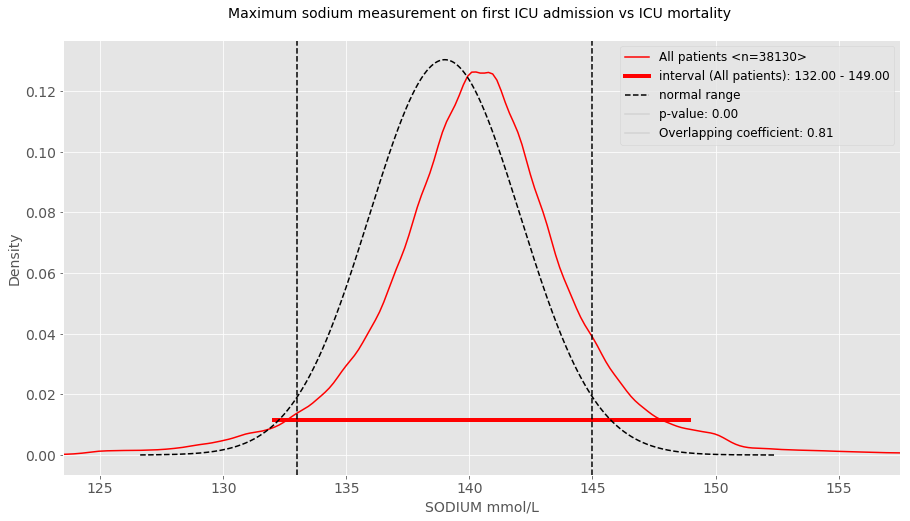

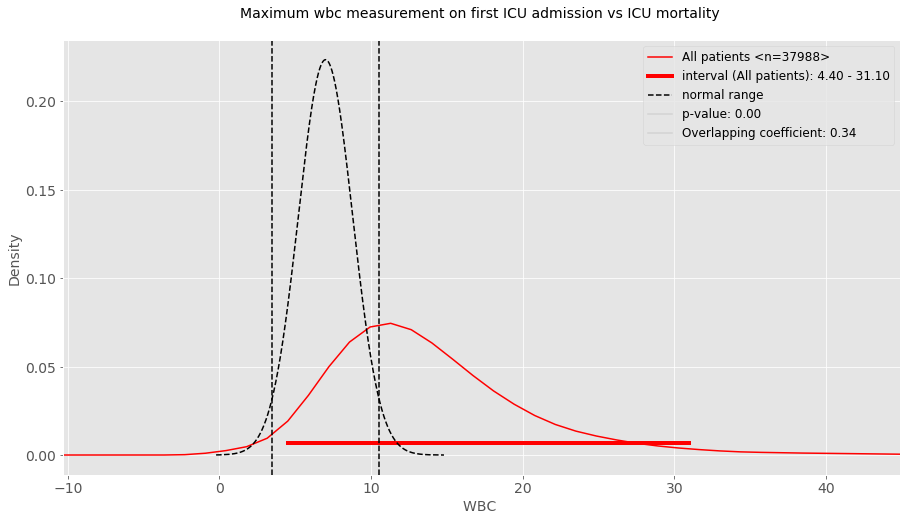

In [9]:
labs = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

LOS_med = data['los'].dropna().median()

#cond_less = (data.mort_icu == 0) & (data.los < LOS_med)
cond_less = data.mort_icu == 0

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_all = data[l.lower()+'_max'].dropna().count()

    # get median, variance, mean
    med_all = data[l.lower()+'_max'].dropna().median()
    var_all = data[l.lower()+'_max'].dropna().var()
    mean_all = data[l.lower()+'_max'].dropna().mean()
    
    # Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[l][0], lab_ranges[l][1])
    norm_sample = range_dist.rvs(size=n_all, random_state=20171024)
    
    # Change to non-parametric test to avoid making assumptions 
    #t_stat, p_val = ttest_ind(norm_sample, data[l.lower()+'_max'].dropna())
    t_stat, p_val = mannwhitneyu(norm_sample, data[l.lower()+'_max'].dropna())

    # plot
    fig, ax = plt.subplots(figsize=(15,8))
    data[l.lower()+'_max'].dropna().plot.kde(
        alpha=1.0,label='All patients <n={}>'.format(n_all), color='r')
    
    # Test case on pandas kde: gaussian kde 
    data_kde = gaussian_kde(data[l.lower()+'_max'].dropna().as_matrix())
    #plt.plot(data[l.lower()+'_min'].dropna().sort_values(), data_kde.pdf(data[l.lower()+'_min'].dropna().sort_values()))
    
    ovl = OverlapParam(data_kde, range_dist, l)
    # add 95% percentail 
    a1 = data[l.lower()+'_max'].quantile(0.025)
    a2 = data[l.lower()+'_max'].quantile(0.975)
    
    # add pixel gap
    dy = 0.5
    i = 1  # 0 for dx
    tmp = ax.transData.transform([(0,0), (1,1)])
    tmp = tmp[1,i] - tmp[0,i]  # 1 unit in display coords
    tmp = 1/tmp  # 1 pixel in display coords
    tmp = tmp*dy*ax.get_figure().get_dpi()  # shift pixels in display coords

    plt.hlines(y=tmp, xmin = a1, xmax = a2, linewidth=4, linestyle='-', color='r')
    
    # Plot label
    plt.plot([], label='interval (All patients): {} - {}'.format(format(a1, '.2f'), format(a2, '.2f')),
                 color='red', linewidth=4)

    if l in lab_ranges and lab_ranges[l]:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--', label='normal range')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot(np.sort(norm_sample), range_dist.pdf(np.sort(norm_sample)), color='black', linestyle='--')
    # add title, labels etc.
    plt.title('Maximum {} measurement on first ICU admission '.format(l.lower()) +
               'vs ICU mortality \n', fontsize=14)
    plt.xlabel(l + ' ' + u, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    plot_range = [min(a1, lab_ranges[l][0]), max(a2, lab_ranges[l][1])]
    diff = plot_range[1] - plot_range[0]
    plt.xlim(plot_range[0] - 0.5 * diff, plot_range[1] + 0.5 * diff)
    
    plt.tick_params(axis='both', labelsize=14)